In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error


import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os

In [4]:
data = pd.read_csv('/content/train.csv')
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [6]:
data.describe()

,Row ID,Postal Code,Sales
count,9800.000000,9789.000000,9800.000000
mean,4900.500000,55273.322403,230.769059
std,2829.160653,32041.223413,626.651875
min,1.000000,1040.000000,0.444000
25%,2450.750000,23223.000000,17.248000
50%,4900.500000,58103.000000,54.490000
75%,7350.250000,90008.000000,210.605000
max,9800.000000,99301.000000,22638.480000


Missing Data

In [7]:
data[data['Postal Code'].isnull()]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
2234,2235,CA-2018-104066,05/12/2018,10/12/2018,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5274,5275,CA-2016-162887,07/11/2016,09/11/2016,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8798,8799,US-2017-150140,06/04/2017,10/04/2017,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9146,9147,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9147,9148,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9148,9149,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9386,9387,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9387,9388,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9388,9389,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
9389,9390,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04


Row ID, Customer Name, Postal Code are not important to the features

In [8]:
data.drop(['Row ID', 'Customer Name', 'Postal Code'], axis=1, inplace=True)

In [9]:
time_feats = ["Order Date", "Ship Date"]

for col in time_feats:
    data[col] = pd.to_datetime(data[col], infer_datetime_format=True)

In [10]:
data.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,CA-2017-152156,2017-08-11,2017-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,CA-2017-138688,2017-12-06,2017-06-16,Second Class,DV-13045,Corporate,United States,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,US-2016-108966,2016-11-10,2016-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,US-2016-108966,2016-11-10,2016-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [11]:
data.drop_duplicates(inplace=True)

Exploratory Data Analysis

In [12]:
viz_df = data.copy()

In [13]:
geo_feats = ["State", "City"]

for i in geo_feats:
    df = viz_df.groupby(i).sum().sort_values("Sales", ascending=False).head(10)
    df.reset_index(inplace=True)

    fig=px.bar(df, x=i, y='Sales',title="Top 10 "+i,color_discrete_sequence=px.colors.sequential.RdBu)
    fig.show()

In [14]:
cat_feats = ["Ship Mode", "Segment", "Category", "Sub-Category"]

for i in cat_feats:
    fig = px.pie(viz_df, values='Sales', names=i)
    fig.show()

In [15]:
data['Order Date'].sort_values().head(20)

540    2015-01-02
5713   2015-01-03
8309   2015-01-03
6548   2015-01-03
7949   2015-01-03
6547   2015-01-03
157    2015-01-03
7947   2015-01-03
8310   2015-01-03
7948   2015-01-03
7950   2015-01-03
1372   2015-01-04
1373   2015-01-04
7954   2015-01-04
7953   2015-01-04
307    2015-01-06
244    2015-01-06
245    2015-01-06
247    2015-01-06
248    2015-01-06
Name: Order Date, dtype: datetime64[ns]

In [16]:
idx = pd.date_range(min(data["Order Date"]), max(data["Order Date"]))

In [17]:
idx

DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05',
               '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
               '2015-01-10', '2015-01-11',
               ...
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', length=1459, freq='D')

In [18]:
new_time = pd.DataFrame({"Order Date":idx})
# Merge with the clean dataset
data = pd.merge(new_time, data, on="Order Date", how='left')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10028 entries, 0 to 10027
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    10028 non-null  datetime64[ns]
 1   Order ID      9799 non-null   object        
 2   Ship Date     9799 non-null   datetime64[ns]
 3   Ship Mode     9799 non-null   object        
 4   Customer ID   9799 non-null   object        
 5   Segment       9799 non-null   object        
 6   Country       9799 non-null   object        
 7   City          9799 non-null   object        
 8   State         9799 non-null   object        
 9   Region        9799 non-null   object        
 10  Product ID    9799 non-null   object        
 11  Category      9799 non-null   object        
 12  Sub-Category  9799 non-null   object        
 13  Product Name  9799 non-null   object        
 14  Sales         9799 non-null   float64       
dtypes: datetime64[ns](2), float64(1), ob

Data Preparation

In [20]:
data.head(20)

,Order Date,Order ID,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,2015-01-02,CA-2015-140795,2015-03-02,First Class,BD-11500,Consumer,United States,Green Bay,Wisconsin,Central,TEC-AC-10001432,Technology,Accessories,Enermax Aurora Lite Keyboard,468.900
1,2015-01-03,CA-2015-104269,2015-06-03,Second Class,DB-13060,Consumer,United States,Seattle,Washington,West,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,457.568
2,2015-01-03,US-2015-143707,2015-05-03,Standard Class,HR-14770,Home Office,United States,New York City,New York,East,TEC-PH-10003655,Technology,Phones,Sannysis Cute Owl Design Soft Skin Case Cover ...,5.940
3,2015-01-03,CA-2015-113880,2015-05-03,Standard Class,VF-21715,Home Office,United States,Elmhurst,Illinois,Central,FUR-CH-10000863,Furniture,Chairs,Novimex Swivel Fabric Task Chair,634.116
4,2015-01-03,CA-2015-113880,2015-05-03,Standard Class,VF-21715,Home Office,United States,Elmhurst,Illinois,Central,OFF-PA-10003036,Office Supplies,Paper,"Black Print Carbonless 8 1/2"" x 8 1/4"" Rapid M...",17.472
5,2015-01-03,CA-2015-131009,2015-05-03,Standard Class,SC-20380,Consumer,United States,El Paso,Texas,Central,OFF-FA-10004395,Office Supplies,Fasteners,Plymouth Boxed Rubber Bands by Plymouth,18.840
6,2015-01-03,CA-2015-131009,2015-05-03,Standard Class,SC-20380,Consumer,United States,El Paso,Texas,Central,FUR-CH-10001270,Furniture,Chairs,Harbour Creations Steel Folding Chair,362.250
7,2015-01-03,CA-2015-131009,2015-05-03,Standard Class,SC-20380,Consumer,United States,El Paso,Texas,Central,FUR-FU-10001095,Furniture,Furnishings,DAX Black Cherry Wood-Tone Poster Frame,63.552
8,2015-01-03,CA-2015-131009,2015-05-03,Standard Class,SC-20380,Consumer,United States,El Paso,Texas,Central,OFF-ST-10001469,Office Supplies,Storage,Fellowes Bankers Box Recycled Super Stor/Drawer,129.552
9,2015-01-03,CA-2015-168312,2015-07-03,Standard Class,GW-14605,Consumer,United States,Houston,Texas,Central,OFF-ST-10003692,Office Supplies,Storage,Recycled Steel Personal File for Hanging File ...,137.352


In [21]:
# Aggregate all daily revenue
time_sales = data.groupby("Order Date").sum()
time_sales

,Sales
Order Date,
2015-01-02,468.9000
2015-01-03,2203.1510
2015-01-04,119.8880
2015-01-05,0.0000
2015-01-06,5188.5200
...,...
2018-12-26,814.5940
2018-12-27,177.6360
2018-12-28,1657.3508


In [22]:
time_sales1 = time_sales.copy()
time_sales1.reset_index(inplace=True)

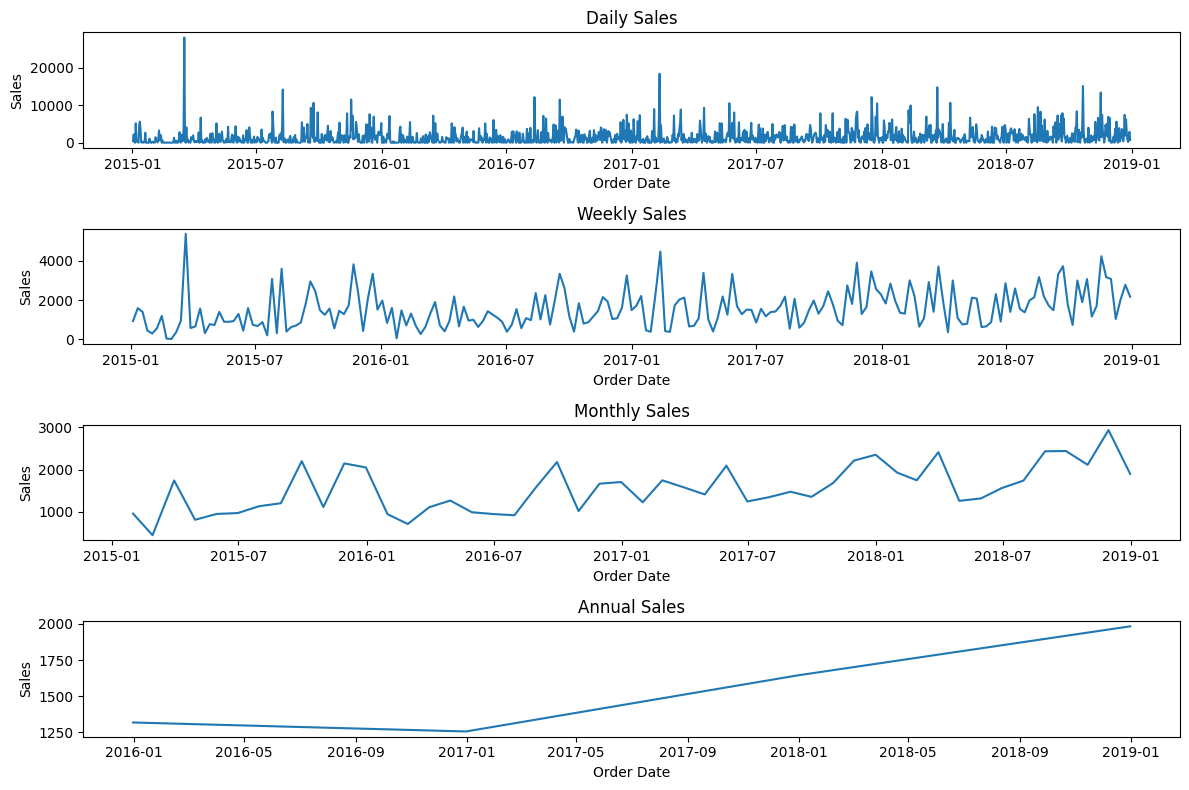

In [23]:
sale_weekly = time_sales1.resample('W', on='Order Date').mean()


sale_monthly = time_sales1.resample('M', on='Order Date').mean()


sale_annualy = time_sales1.resample('A', on='Order Date').mean()


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,8))

sns.lineplot(x='Order Date', y='Sales', data=time_sales1, ax=ax1)
ax1.set_title('Daily Sales')

sns.lineplot(x='Order Date', y='Sales', data=sale_weekly, ax=ax2)
ax2.set_title('Weekly Sales')

sns.lineplot(x='Order Date', y='Sales', data=sale_monthly, ax=ax3)
ax3.set_title('Monthly Sales')

sns.lineplot(x='Order Date', y='Sales', data=sale_annualy, ax=ax4)
ax4.set_title('Annual Sales')

plt.tight_layout()

Seasonal Decomposition

In [24]:
decomposition = seasonal_decompose(sale_monthly, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

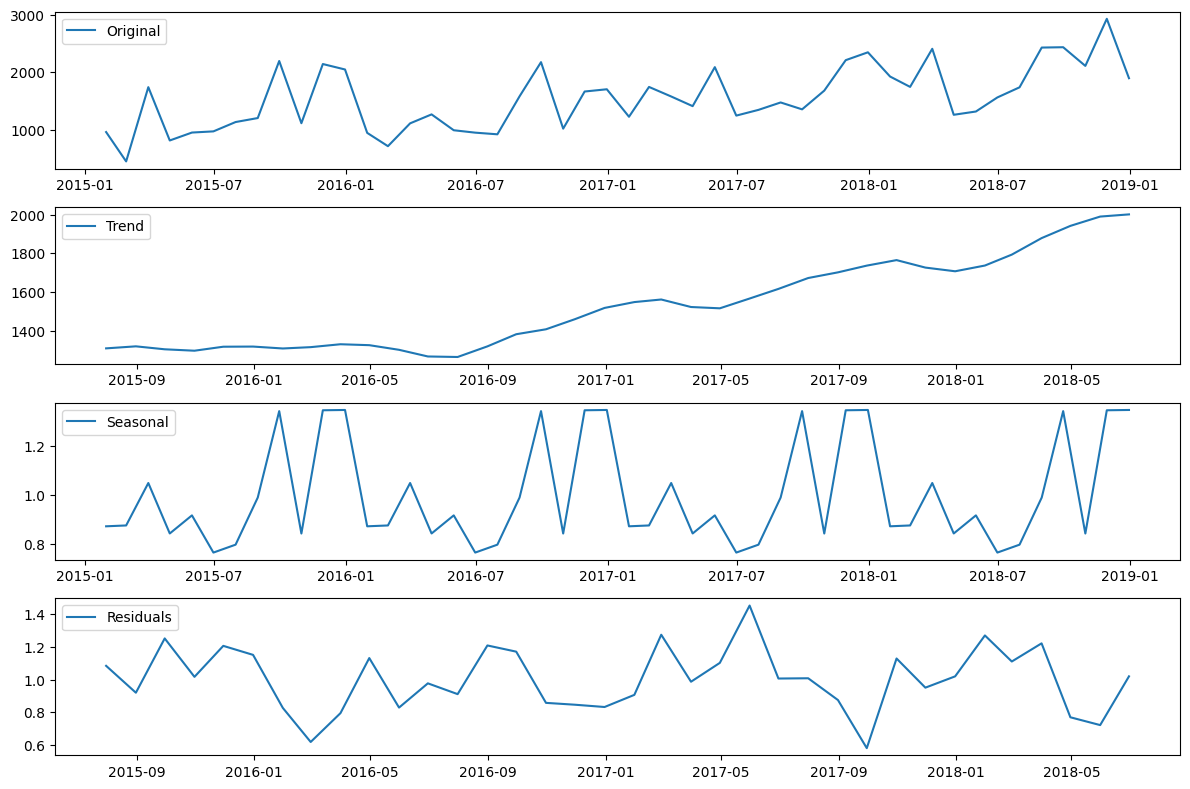

In [25]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(sale_monthly, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

Train-Test

In [26]:
size = 0.8
# split the dataset
train, test = sale_monthly.iloc[:int(size*len(sale_monthly))], sale_monthly.iloc[int(size*len(sale_monthly)):]

In [27]:
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print("ADF Test Result:")
    print(f'ADF Statistic: {adf_statistic}')
    print(f'p-value: {p_value}')
    print(f'Critical Values: {critical_values}')
    print('\n')
    if adf_statistic < critical_values["5%"] and p_value < 0.05:
        print('The time series is likely stationary (i.e. Reject the Null Hypothesis)')
    else:
        print('The time series is likely non-stationary (i.e. Do not reject the Null Hypothesis)')

In [28]:
test_stationarity(train["Sales"])

ADF Test Result:
ADF Statistic: -4.516504957882659
p-value: 0.00018356877036335533
Critical Values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}


The time series is likely stationary (i.e. Reject the Null Hypothesis)


Identify Parameters

In [29]:
model_param = auto_arima(train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=580.132, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=571.622, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=578.181, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=572.711, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=573.535, Time=0.72 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=573.516, Time=0.94 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=572.063, Time=0.31 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=578.413, Time=0.36 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=570.204, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=569.842, Time=0.30 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=570.648, Time=0.17 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=57

Building the model

In [30]:
order = (0, 1, 1)  # (p, d, q)
seasonal_order = (1, 0, 0, 12)  # (P, D, Q, s)

Train the model in Train set

In [31]:
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
train_model = model.fit()

In [32]:
train_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Sales   No. Observations:                   38
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -278.510
Date:                             Mon, 07 Aug 2023   AIC                            563.020
Time:                                     16:32:02   BIC                            567.852
Sample:                                 01-31-2015   HQIC                           564.723
                                      - 02-28-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8442      0.092     -9.176      0.000      -1.025      -0.664
ar.S.L12       0.4206      0.157      2.680      0.007       0.113       0.728
sigma2      1.798e+05    4.9e+04      3.667      0.000    8.37e+04    2.76e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.81   Prob(JB):                         0.30
Heteroskedasticity (H):               0.55   Skew:                             0.51
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Prediction

In [33]:
test_stationarity(test["Sales"])


ADF Test Result:
ADF Statistic: -5.861074795669109
p-value: 3.4093627548362857e-07
Critical Values: {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}


The time series is likely stationary (i.e. Reject the Null Hypothesis)


predicting on test set

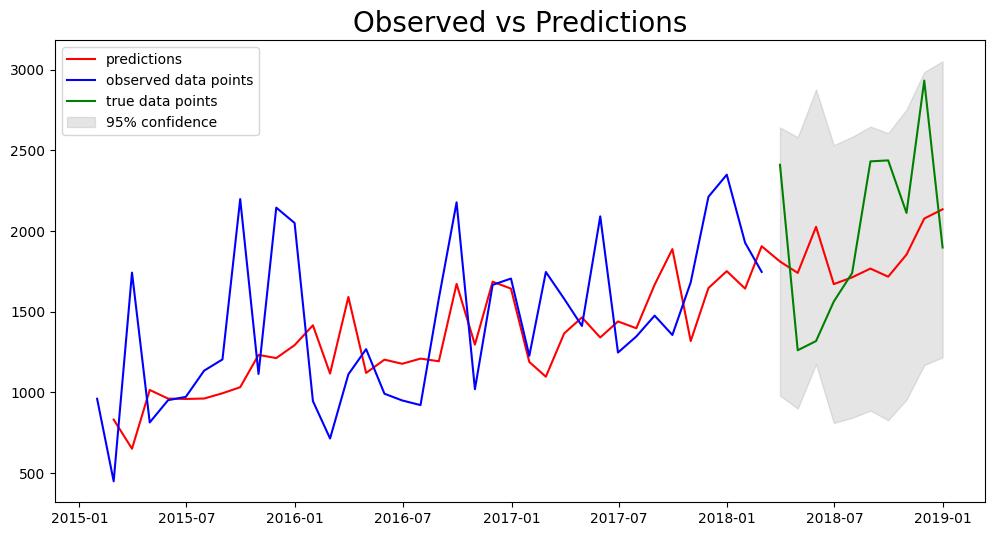

In [34]:
pred = train_model.get_prediction(start='2015-01-31', end='2018-12-31')
# get the confidence interval
CI = pred.conf_int()
test_CI = CI.loc[test.index[0]:]

#plot the results
plt.figure(figsize=(12,6))
plt.plot(pred.predicted_mean[1:],color='red',label='predictions')
plt.plot(train,color='blue',label='observed data points')
plt.plot(test,color='green',label='true data points')
plt.fill_between(test_CI.index, test_CI.iloc[:,0], test_CI.iloc[:,1], color='gray', alpha=.2, label='95% confidence')

plt.title('Observed vs Predictions',size=20)
plt.legend(loc='best')

Evaluation Metrics

In [35]:
forecast_error = sale_monthly['Sales'][1:] - pred.predicted_mean[1:]

# Mean forecast error
mean_forecast_error = np.mean(forecast_error)
print(mean_forecast_error)

132.717988381754


In [36]:
print(f"Mean Absolute Error: {mean_absolute_error(sale_monthly,pred.predicted_mean)}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(sale_monthly,pred.predicted_mean)}")

Mean Absolute Error: 391.5608206279206
Mean Absolute Percentage Error: 0.26361165688513455


Applying the Model on the full dataset

In [37]:
full_model = SARIMAX(sale_monthly, order=order, seasonal_order=seasonal_order)
results = full_model.fit()

In [38]:
new_pred = results.get_prediction(start='2015-01-31', end='2018-12-31')

In [39]:
forecast_periods = 10 # Number of future periods to forecast: 10 months
forecast = results.get_forecast(steps=forecast_periods)

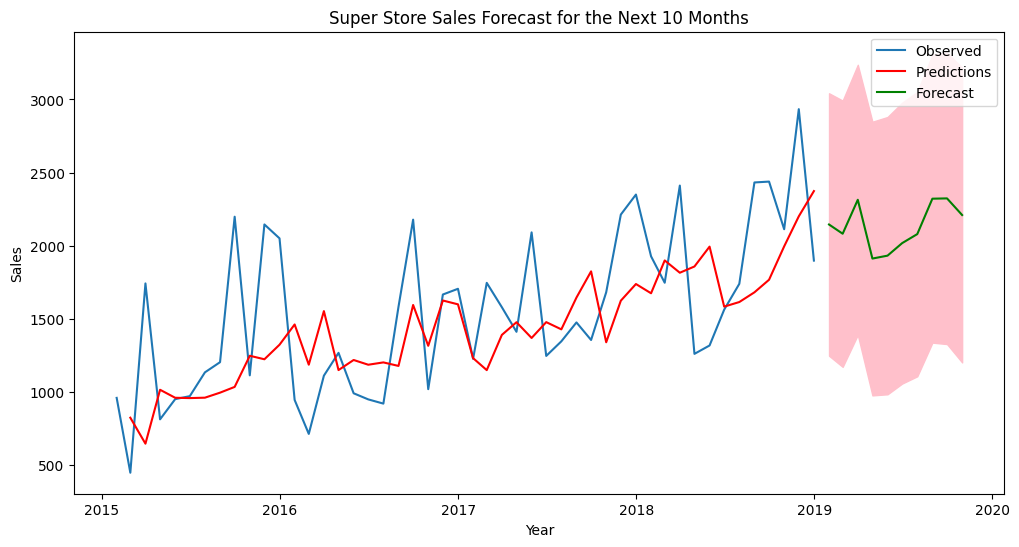

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(sale_monthly, label='Observed')
plt.plot(new_pred.predicted_mean[1:], color='red', label='Predictions')
plt.plot(forecast.predicted_mean, color='green', label='Forecast')
plt.fill_between(forecast.conf_int().index, forecast.conf_int()['lower Sales'], forecast.conf_int()['upper Sales'], color='pink')

plt.title("Super Store Sales Forecast for the Next 10 Months")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend(loc='best')
plt.show()